In [2]:
%cd ~/projects/GraB-lib

%load_ext autoreload
%autoreload 1

/home/aris/projects/GraB-lib


In [3]:
from torch import nn

import os
import sys
from functools import partial, reduce
from pathlib import Path
from dataclasses import dataclass, field

import evaluate
import numpy as np
import pandas as pd
import wandb
from tqdm import tqdm
from absl import logging

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from transformers import (
    HfArgumentParser, TrainingArguments, set_seed
)

import torchopt
from torch.func import (
    grad, grad_and_value, vmap, functional_call
)

from grabngo import GraBSampler, BalanceType
from grabngo.utils import EventTimer, pretty_time

from experiments.cv.models import LeNet

In [4]:
device = "cuda"
batch_size = 16
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.49139968, 0.48215841, 0.44653091],
            std=[0.24703223, 0.24348513, 0.26158784],
        ),
    ]
)

# Loading the dataset and preprocessing
train_dataset = datasets.CIFAR10(
    root="data/external", train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root="data/external", train=False, download=True, transform=transform
)

in_dim, num_classes = 3, 10

loss_fn = nn.CrossEntropyLoss().to(device)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    # sampler=sampler,
    persistent_workers=False,
    num_workers=1,
    pin_memory=True,
)
train_eval_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    persistent_workers=False,
    num_workers=1,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    persistent_workers=False,
    num_workers=1,
    pin_memory=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_loader), shuffle=False)

data, targets = next(iter(loader))

logging.set_verbosity(logging.INFO)

In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [49]:
from torch import optim
from transformers import set_seed


@torch.no_grad()
def visual_weights(weights: nn.Module, start_idx=0, size=10, filename="weight.png"):
    weight = torch.cat([p.view(-1) for p in weights.parameters()])

    return weight[start_idx : start_idx + size * size].view(size, -1).cpu().numpy()


set_seed(42)
model = LeNet().cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0, weight_decay=0.01)

step = 0
frames = []
for epoch in range(10):
    for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            frames.append(visual_weights(
                model, filename=f"sandbox/gary/lazy_training/weights/weight_{step}.png",
                size = 200
            ))
            torch.save(model.state_dict(), f"sandbox/gary/lazy_training/weights/weight_{step}.pt")
        step += 1
        

100%|██████████| 3125/3125 [00:12<00:00, 251.78it/s]


In [50]:
import imageio

images = []
for idx in range(87):
    step = idx * 100
    images.append(imageio.v2.imread(f"sandbox/gary/lazy_training/imgs/weight_{step}.png"))
imageio.mimsave(f"sandbox/gary/lazy_training/imgs/weights.gif", images)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 images = []                                                                                  │
│   4 for idx in range(87):                                                                        │
│   5 │   step = idx * 100                                                                         │
│ ❱ 6 │   images.append(imageio.v2.imread(f"sandbox/gary/lazy_training/imgs/weight_{step}.png"     │
│   7 imageio.mimsave(f"sandbox/gary/lazy_training/imgs/weights.gif", images)                      │
│   8                                                                                              │
│                                                                                                  │
│ /home/aris/mambaforge/envs/grab/lib/python3.10/site-packages/imageio/v2.py:359 in imread         │
│                                                                                                  │
│   356 │   imopen_args = decypher_format_arg(format)                                              │
│   357 │   imopen_args["legacy_mode"] = True                                                      │
│   358 │                                                                                          │
│ ❱ 359 │   with imopen(uri, "ri", **imopen_args) as file:                                         │
│   360 │   │   result = file.read(index=0, **kwargs)                                              │
│   361 │                                                                                          │
│   362 │   return result                                                                          │
│                                                                                                  │
│ /home/aris/mambaforge/envs/grab/lib/python3.10/site-packages/imageio/core/imopen.py:113 in       │
│ imopen                                                                                           │
│                                                                                                  │
│   110 │   │   io_mode = request.mode.io_mode                                                     │
│   111 │   │   request.format_hint = format_hint                                                  │
│   112 │   else:                                                                                  │
│ ❱ 113 │   │   request = Request(uri, io_mode, format_hint=format_hint, extension=extension)      │
│   114 │                                                                                          │
│   115 │   source = "<bytes>" if isinstance(uri, bytes) else uri                                  │
│   116                                                                                            │
│                                                                                                  │
│ /home/aris/mambaforge/envs/grab/lib/python3.10/site-packages/imageio/core/request.py:247 in      │
│ __init__                                                                                         │
│                                                                                                  │
│   244 │   │   │   raise ValueError(f"Invalid Request.Mode: {mode}")                              │
│   245 │   │                                                                                      │
│   246 │   │   # Parse what was given                                                             │
│ ❱ 247 │   │   self._parse_uri(uri)                                                               │
│   248 │   │                                                                                      │
│   249 │   │   # Set extension                              

In [51]:
frames_bak = frames

ub, lb = -np.inf, np.inf
for frame in frames:
    ub = max(ub, frame.max())
    lb = min(lb, frame.min())
print(ub, lb)

0.6580074 -0.523791


In [52]:
import os

os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

from moviepy.editor import ImageSequenceClip

frames = ((np.array(frames_bak) + 1)*.5*256).astype(np.uint8)
frames = np.repeat(frames[:, :, :, None], 3, axis=3)

clip = ImageSequenceClip(list(frames), fps=20)
clip.write_gif(f"sandbox/gary/lazy_training/weights.gif", fps=20)

t:   0%|          | 1/301 [12:32<62:40:53, 752.18s/it, now=None]

MoviePy - Building file sandbox/gary/lazy_training/weights.gif with imageio.


In [55]:
def unfold_model(model):
    return torch.cat([
        p.view(-1) for p in model.parameters()
    ])

trained_weights = unfold_model(model)

set_seed(42)
init_weights = unfold_model(LeNet().cuda())

diff = trained_weights - init_weights

In [70]:
print(diff.shape)
print(diff.abs().max())
print(diff.mean())

sorted = torch.sort(diff, descending=True)

torch.Size([62006])
tensor(0.6037, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)


(array([ 248.,  464.,  763., 1288., 2107., 3463., 4621., 5383., 5718.,
        5809., 6079., 5707., 5419., 4830., 3567., 2207., 1399.,  842.,
         543.,  282.]),
 array([-0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
        -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
         0.08,  0.09,  0.1 ]),
 <BarContainer object of 20 artists>)

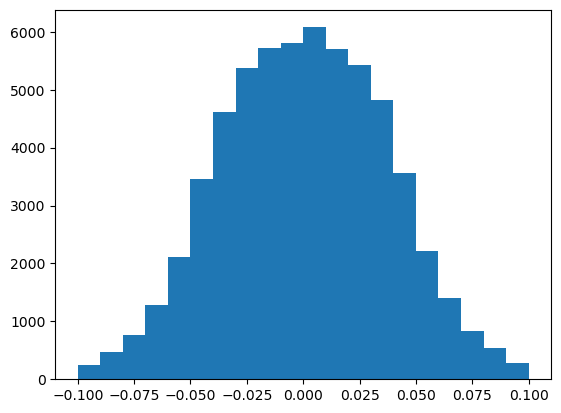

In [74]:
plt.hist(sorted.values.cpu().detach().numpy(), bins=20, range=(-.1, .1))